In [3]:
%pip install pdf2image
%pip install pytesseract
%pip install xlsxwriter
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

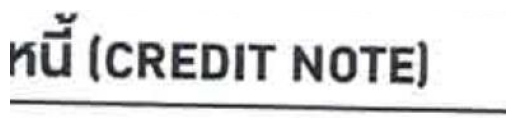

In [3]:
import cv2
import pytesseract
from matplotlib import pyplot as plt

# กำหนดพาธของไฟล์ภาพ
image_path = "test_BKI_JPG/bki_337249.jpg"

# โหลดภาพและกำหนดพิกเซลที่สนใจ
image = cv2.imread(image_path)
x1, y1, x2, y2 = 1100, 385, 1490, 470
roi = image[y1:y2, x1:x2]

# ทำ OCR บนส่วนที่เลือก
#text = pytesseract.image_to_string(roi, lang='eng+tha')
#print("ข้อความที่ได้จาก OCR:", text)

# แสดงภาพที่เลือก
plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()



In [6]:
import cv2
import os
import numpy as np
import pytesseract
import re
import imutils
import pandas as pd
import xlsxwriter
import shutil

# ระบุโฟลเดอร์ที่มีไฟล์ภาพ
folder_path = 'test_BKI_JPG'

# ดึงรายการของไฟล์ภาพในโฟลเดอร์
image_files = os.listdir(folder_path)

# วนลูปผ่านไฟล์ภาพแต่ละไฟล์
for filename in image_files:
    # ตั้งค่าที่อยู่ของไฟล์ภาพ
    image_path = os.path.join(folder_path, filename)

    # โหลดภาพ
    image = cv2.imread(image_path)

    # ตรวจสอบว่าภาพถูกโหลดเข้ามาหรือไม่
    if image is not None:
        # Convert image to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Apply GaussianBlur to reduce noise
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)

        # Apply Canny edge detection
        edges = cv2.Canny(blurred, 50, 150)

        # Find contours
        contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Filter out small contours and long lines
        min_contour_area = 1000
        min_line_length = 400
        max_angle = -np.inf
        max_angle_lines = []
        for contour in contours:
            epsilon = 0.02 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)
            if len(approx) >= 2:  # Check if the contour is approximated by at least 2 points (a line)
                # Iterate over each pair of points to calculate line length
                for i in range(len(approx) - 1):
                    x1, y1 = approx[i][0]
                    x2, y2 = approx[i + 1][0]
                    line_length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
                    angle = np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi
                    if abs(angle) < 10 or abs(angle - 180) < 10:
                        if line_length > min_line_length:
                            if abs(angle) > max_angle:
                                max_angle = abs(angle)
                                max_angle_lines = [(x1, y1), (x2, y2)]

        # Draw the line with maximum angle
        if max_angle_lines:
            x1, y1 = max_angle_lines[0]
            x2, y2 = max_angle_lines[1]
            # Generate random color
            color = (np.random.randint(0, 256), np.random.randint(0, 256), np.random.randint(0, 256))
            cv2.line(image, (x1, y1), (x2, y2), color, 2)

        # Filter contours with area greater than the specified threshold
        min_contour_area = 1
        filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]

        # Check if no contours are found
        if not filtered_contours:
            print(f"ไม่พบเส้นขอบในไฟล์ {filename}")
            continue

        # Update the image rotation code
        for contour in filtered_contours:
            # Determine the type of contour
            epsilon = 0.02 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)
            if len(approx) == 2:  # Straight line
                # Calculate the angle of the line
                angle = np.degrees(np.arctan((y2 - y1) / (x2 - x1)))

                # Get the image dimensions
                height, width = image.shape[:2]

                # Set the center point as the midpoint of the image
                center = (width // 2, height // 2)

                # Rotate the image
                height, width = image.shape[:2]
                rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1)
                rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))

                # ตรวจสอบว่าสามารถโหลดภาพได้หรือไม่
                if image is None:
                    print("ไฟล์ภาพเสีย")
                else:
                    # ขั้นตอนประมวลผลภาพ
                    # กำหนดพิกัดในการครอบภาพ
                    x1, y1, x2, y2 = 1900, 240, 2205, 310
                    cropped_image = image[y1:y2, x1:x2]

                    # ตรวจสอบว่าภาพที่ครอบออกมามีขนาดว่างเปล่าหรือไม่
                    filename = ("{}".format(filename))  # ชื่อไฟล์ของภาพที่กำลังใช้อยู่
                    if cropped_image.size == 0:
                        print("{} ขนาดภาพไม่ถูกต้อง".format(filename))

                        # ไฟล์ที่ต้องการย้าย
                        source_path = "test_BKI_JPG" + filename

                        # กำหนดตำแหน่งที่ต้องการย้ายไฟล์ไป
                        destination = "fail_BKI"
                        shutil.move(source_path, destination)
                    else:
                        # ประเภท
                        x1, y1, x2, y2 = 1100, 385, 1490, 470
                        new_width = 100  # กำหนดค่าตามที่คุณต้องการ
                        new_height = 100  # กำหนดค่าตามที่คุณต้องการ
                        resized_image = cv2.resize(rotated_image, (new_width, new_height))
                        cropped_image = rotated_image[y1:y2, x1:x2]
                        enhanced_image = cv2.convertScaleAbs(resized_image, alpha=1.495, beta=-70)
                        #cv2_imshow(cropped_image)
                        # Uncomment this line if you want to display the cropped image
                        custom_config = r'--oem 3 --psm 6'
                        text = pytesseract.image_to_string(cropped_image, lang='eng', config=custom_config)
                        print("31mข้อความที่แสกนได้จากไฟล์ {}".format(filename))

                        # Find the indices of opening and closing brackets
                        opening_brackets = ["(", "{", "["]
                        closing_brackets = [")", "}", "]"]
                        # Find the first opening bracket
                        opening_indexes = [text.find(bracket) for bracket in opening_brackets if text.find(bracket) != -1]
                        closing_indexes = [text.rfind(bracket) for bracket in closing_brackets if text.rfind(bracket) != -1]
                        # Check if the lists are not empty before using min() and max()
                        if opening_indexes:
                            opening_index = min(opening_indexes)
                        if closing_indexes:
                            closing_index = max(closing_indexes)
                        # Extract the text between the opening and closing brackets
                        if 'opening_index' in locals() and 'closing_index' in locals() and opening_index != -1 and closing_index != -1:
                            extracted_text = text[opening_index + 1 : closing_index]
                            TYPE = extracted_text
                            print("ประเภท:", TYPE)
                        else:
                            print("ไม่พบเครื่องหมายเปิดและปิดคำสั่งในข้อความ")



                        # วันที่
                        x1, y1, x2, y2 = 1900, 240, 2205, 310
                        cropped_image = rotated_image[y1:y2, x1:x2]
                        # แปลงภาพเป็นภาพสีเทา
                        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                        # ทำการกรองภาพแบบ Bilateral Filtering เพื่อลด noise และเพิ่มความคมชัดของภาพ
                        filtered_image = cv2.bilateralFilter(image, d=9, sigmaColor=75, sigmaSpace=75)
                        # ขยายภาพ
                        scale_percent = 170  # เปอร์เซ็นต์ของการขยายภาพ
                        width = int(cropped_image.shape[1] * scale_percent / 100)
                        height = int(cropped_image.shape[0] * scale_percent / 100)
                        dim = (width, height)
                        resized_image = cv2.resize(cropped_image, dim, interpolation=cv2.INTER_AREA)
                        # ปรับสีให้เห็นชัดขึ้น
                        enhanced_image = cv2.convertScaleAbs(resized_image, alpha=1.495, beta=-70)
                        #cv2_imshow( enhanced_image)#
                        # ใช้ EasyOCR เพื่ออ่านข้อความ
                        # reader = easyocr.Reader(['en', 'th'], gpu= True)
                        reader = pytesseract
                        custom_config = r'--oem 3 --psm 6'
                        result = reader.image_to_string(enhanced_image, config=custom_config)
                        # ใช้ Regular Expression เพื่อคัดแยกเฉพาะตัวเลข 0-9 และเครื่องหมาย /
                        filtered_result = re.findall(r'[\d/]+', result)
                        pattern = r'(0[1-9]|1[0-9]|2[0-9]|3[01])/(0[1-9]|1[012])/(\d{4})'
                        # พิมพ์ผลลัพธ์ที่คัดแยกแล้ว
                        #print("ผลลัพธ์การสแกน:")
                        matches = re.findall(pattern, result)
                        # ตรวจสอบว่ามีผลลัพธ์หรือไม่
                        if not matches:
                            print("หาผลลัพธ์ไม่เจอ")
                        else:
                            print("ผลลัพธ์การสแกน:")
                            for match in matches:
                                DAY = "{}/{}/{}".format(match[0], match[1], match[2])
                                print("วัน:",DAY)




                        # ชื่อ
                        x1, y1, x2, y2 = 150, 580, 605, 720
                        cropped_image = rotated_image[y1:y2, x1:x2]
                        # ขยายภาพ
                        scale_percent = 200  # เปอร์เซ็นต์ของการขยายภาพ
                        width = int(cropped_image.shape[1] * scale_percent / 100)
                        height = int(cropped_image.shape[0] * scale_percent / 100)
                        dim = (width, height)
                        resized_image = cv2.resize(cropped_image, dim, interpolation=cv2.INTER_AREA)
                        # แปลงภาพเป็นภาพสีเทา
                        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                        # ทำการกรองภาพแบบ Bilateral Filtering เพื่อลด noise และเพิ่มความคมชัดของภาพ
                        filtered_image = cv2.bilateralFilter(image, d=9, sigmaColor=75, sigmaSpace=75)
                        # ขยายภาพ
                        scale_percent = 170  # เปอร์เซ็นต์ของการขยายภาพ
                        width = int(cropped_image.shape[1] * scale_percent / 100)
                        height = int(cropped_image.shape[0] * scale_percent / 100)
                        dim = (width, height)
                        resized_image = cv2.resize(cropped_image, dim, interpolation=cv2.INTER_AREA)
                        # ปรับสีให้เห็นชัดขึ้น
                        enhanced_image = cv2.convertScaleAbs(resized_image, alpha=1.495, beta=-70)
                        #cv2_imshow( enhanced_image)#
                        # ใช้ EasyOCR เพื่ออ่านข้อความ
                        # reader = easyocr.Reader(['en', 'th'], gpu= True)
                        reader = pytesseract
                        custom_config = r'--oem 3 --psm 6'
                        name = reader.image_to_string(enhanced_image,lang='tha', config=custom_config)
                        # กำหนดพารามิเตอร์
                        # แปลงภาพเป็นข้อความโดยใช้ pytesseract
                        #cv2_imshow(cropped_image)
                        # แสดงข้อความที่ได้
                        print("ชื่อ: {}".format(name),end='')



                        # เลขกรมธรรม์
                        x1, y1, x2, y2 = 320, 995, 790, 1090
                        cropped_image = rotated_image[y1:y2, x1:x2]
                        # กำหนดพารามิเตอร์
                        # แปลงภาพเป็นข้อความโดยใช้ pytesseract
                        #cv2_imshow(cropped_image)
                        custom_config = r'--oem 3 --psm 6'
                        text = pytesseract.image_to_string(cropped_image, lang='tha+eng', config=custom_config)
                        filtered_result = re.findall(r'[0-9-]+', result)
                        # ค้นหาเลขที่มีอยู่ในข้อความที่ได้จาก OCR
                        numbers = re.findall(r'\d+', text)
                        # ตรวจสอบว่ามีเลขที่สองตัวท้ายเป็น 10 หรือ 11 หรือไม่
                        if len(numbers) > 0:
                            last_number = numbers[-1]
                            if last_number.endswith("10") or last_number.endswith("1"):
                                # ลบเลข 10 หรือ 11 ที่พบในสองตัวท้ายของเลข
                                numbers[-1] = last_number[:-2]
                        # แสดงผลลัพธ์ที่ได้หลังจากลบเลข 10 หรือ 1
                        KTM_number = " ".join(numbers)
                        print("เลขกรมธรรม์: {}".format(KTM_number))



                        # เบี้ยประกันภัยที่เปลี่ยนแปลง
                        x1, y1, x2, y2 = 2000, 675, 2305, 850
                        cropped_image = rotated_image[y1:y2, x1:x2]
                        # ขยายภาพ
                        scale_percent = 200  # เปอร์เซ็นต์ของการขยายภาพ
                        width = int(cropped_image.shape[1] * scale_percent / 100)
                        height = int(cropped_image.shape[0] * scale_percent / 100)
                        dim = (width, height)
                        resized_image = cv2.resize(cropped_image, dim, interpolation=cv2.INTER_AREA)
                        # แปลงภาพเป็นภาพสีเทา
                        gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
                        # ทำการกรองภาพแบบ Bilateral Filtering เพื่อลด noise และเพิ่มความคมชัดของภาพ
                        filtered_image = cv2.bilateralFilter(gray, d=9, sigmaColor=75, sigmaSpace=75)
                        # แสดงภาพ
                        # ปรับสีให้เห็นชัดขึ้น
                        enhanced_image = cv2.convertScaleAbs(filtered_image, alpha=1.5, beta=-70)
                        # แสดงภาพ
                        #cv2_imshow( enhanced_image)
                        # แปลงภาพเป็นข้อความโดยใช้ pytesseract
                        custom_config = r'--oem 3 --psm 6'
                        text = pytesseract.image_to_string(enhanced_image, lang='eng',config=custom_config)
                        #print("เบี้ยประกันภัยที่เปลี่ยนแปลง: {}".format(text))
                        if "603" in text:
                            insurance_fee = 600.00
                            stamp_duty = 3.00
                        elif "904" in text:
                            insurance_fee = 900.00
                            stamp_duty = 4.00
                        else:
                            insurance_fee = "ไม่พบ"
                            stamp_duty = "ไม่พบ"

                        print("เบี้ยประกันภัยที่เปลี่ยนแปลง:", insurance_fee)
                        print("อากรแสตมป์:", stamp_duty)


                        # ผลต่าง
                        x1, y1, x2, y2 = 2000, 920, 2305, 1050
                        cropped_image = rotated_image[y1:y2, x1:x2]
                        # ขยายภาพ
                        scale_percent = 200  # เปอร์เซ็นต์ของการขยายภาพ
                        width = int(cropped_image.shape[1] * scale_percent / 100)
                        height = int(cropped_image.shape[0] * scale_percent / 100)
                        dim = (width, height)
                        resized_image = cv2.resize(cropped_image, dim, interpolation=cv2.INTER_AREA)
                        # แปลงภาพเป็นภาพสีเทา
                        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                        # ทำการกรองภาพแบบ Bilateral Filtering เพื่อลด noise และเพิ่มความคมชัดของภาพ
                        filtered_image = cv2.bilateralFilter(image, d=9, sigmaColor=75, sigmaSpace=75)
                        # ขยายภาพ
                        scale_percent = 170  # เปอร์เซ็นต์ของการขยายภาพ
                        width = int(cropped_image.shape[1] * scale_percent / 100)
                        height = int(cropped_image.shape[0] * scale_percent / 100)
                        dim = (width, height)
                        resized_image = cv2.resize(cropped_image, dim, interpolation=cv2.INTER_AREA)
                        # ปรับสีให้เห็นชัดขึ้น
                        enhanced_image = cv2.convertScaleAbs(resized_image, alpha=1.495, beta=-70)
                        #cv2_imshow(enhanced_image)
                        # ใช้ EasyOCR เพื่ออ่านข้อความ
                        # reader = easyocr.Reader(['en', 'th'], gpu= True)
                        reader = pytesseract
                        custom_config = r'--oem 3 --psm 6'
                        result = reader.image_to_string(enhanced_image, config=custom_config)
                        # ใช้ Regular Expression เพื่อคัดแยกเฉพาะตัวเลข 0-9 และเครื่องหมาย /
                        filtered_result = re.findall(r'\d+\.\d+', result)
                        # พิมพ์ผลลัพธ์ที่คัดแยกแล้ว
                        print("Balanc: ", end='')
                        for B_text in filtered_result:
                            print(B_text)



                        # VAT
                        x1, y1, x2, y2 = 2000, 1020, 2305, 1150
                        cropped_image = rotated_image[y1:y2, x1:x2]
                        # ขยายภาพ
                        scale_percent = 200  # เปอร์เซ็นต์ของการขยายภาพ
                        width = int(cropped_image.shape[1] * scale_percent / 100)
                        height = int(cropped_image.shape[0] * scale_percent / 100)
                        dim = (width, height)
                        resized_image = cv2.resize(cropped_image, dim, interpolation=cv2.INTER_AREA)
                        # แปลงภาพเป็นภาพสีเทา
                        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                        # ทำการกรองภาพแบบ Bilateral Filtering เพื่อลด noise และเพิ่มความคมชัดของภาพ
                        filtered_image = cv2.bilateralFilter(image, d=9, sigmaColor=75, sigmaSpace=75)
                        # ขยายภาพ
                        scale_percent = 170  # เปอร์เซ็นต์ของการขยายภาพ
                        width = int(cropped_image.shape[1] * scale_percent / 100)
                        height = int(cropped_image.shape[0] * scale_percent / 100)
                        dim = (width, height)
                        resized_image = cv2.resize(cropped_image, dim, interpolation=cv2.INTER_AREA)
                        # ปรับสีให้เห็นชัดขึ้น
                        enhanced_image = cv2.convertScaleAbs(resized_image, alpha=1.495, beta=-70)
                        #cv2_imshow(enhanced_image)
                        # ใช้ EasyOCR เพื่ออ่านข้อความ
                        # reader = easyocr.Reader(['en', 'th'], gpu= True)
                        reader = pytesseract
                        custom_config = r'--oem 3 --psm 6'
                        result = reader.image_to_string(enhanced_image, config=custom_config)
                        # ใช้ Regular Expression เพื่อคัดแยกเฉพาะตัวเลข 0-9 และเครื่องหมาย /
                        filtered_result = re.findall(r'\d+\.\d+', result)
                        # พิมพ์ผลลัพธ์ที่คัดแยกแล้ว
                        print("VAT: ", end='')
                        for V_text in filtered_result:
                            print(V_text)



                        # total
                        x1, y1, x2, y2 = 2000, 1130, 2305, 1220
                        cropped_image = rotated_image[y1:y2, x1:x2]
                        # ขยายขนาดภาพ
                        scale_percent = 200  # เปอร์เซ็นต์ของการขยายภาพ
                        width = int(cropped_image.shape[1] * scale_percent / 100)
                        height = int(cropped_image.shape[0] * scale_percent / 100)
                        dim = (width, height)
                        resized_image = cv2.resize(cropped_image, dim, interpolation=cv2.INTER_AREA)
                        # แปลงภาพเป็นภาพสีเทา
                        gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
                        # กรองภาพแบบ Bilateral Filtering เพื่อลด noise และเพิ่มความคมชัดของภาพ
                        filtered_image = cv2.bilateralFilter(gray, d=9, sigmaColor=75, sigmaSpace=75)
                        # ปรับสีให้เห็นชัดขึ้น
                        enhanced_image = cv2.convertScaleAbs(filtered_image, alpha=1.5, beta=-70)
                        # กำหนดพารามิเตอร์สำหรับ pytesseract
                        custom_config = r'--oem 3 --psm 6'
                        # แปลงภาพเป็นข้อความโดยใช้ pytesseract
                        Total_text = pytesseract.image_to_string(enhanced_image, lang='eng', config=custom_config)
                        #cv2_imshow(cropped_image)
                        #print("{}".format(Total_text))
                        # คัดลอกเฉพาะตัวเลขและจุดทศนิยมสองตำแหน่ง
                        import re
                        matches = re.findall(r'\b\d+\.\d+\b', Total_text)
                        if matches:
                            Total_text = matches[0]
                        else:
                            Total_text = "ไม่พบข้อมูล"
                        print("รวมเป็นเงิน: {}".format(Total_text))

                        # สร้าง DataFrame
                        data = {
                            'ประเภท': [TYPE],
                            'วันที่': [DAY],
                            'ชื่อ': [name],
                            'เลขกรมธรรม์': [KTM_number],
                            'เบี้ยประกันภัยที่เปลี่ยนแปลง': [insurance_fee],
                            'อากรแสตมป์': [stamp_duty],
                            'Balanc': [B_text],
                            'VAT': [V_text],
                            'รวมเป็นเงิน': [Total_text]
                        }
                        # สร้าง DataFrame
                        df = pd.DataFrame(data)
                        # สลับแถวและคอลัมน์
                        df_transposed = df.T
                        # ระบุที่อยู่ของไฟล์ Excel ที่ต้องการสร้าง
                        excel_file = ("{}.xlsx".format(filename))
                        # กำหนด path ของไฟล์ Excel ที่ต้องการบันทึก
                        directory_path = 'excel_BKI'
                        excel_path = os.path.join(directory_path,excel_file)
                        # บันทึกไฟล์ Excel ไปยัง Google Drive
                        #df.to_excel(excel_path, index=False)
                        df.T.to_excel(excel_path, header=False)
                        # แสดงที่อยู่ของไฟล์ Excel ที่ถูกบันทึก
                        print("ไฟล์ Excel ถูกบันทึกที่:", excel_path)



                break
    else:
        print(f"ไม่สามารถโหลดไฟล์ภาพ {filename} ได้")

31mข้อความที่แสกนได้จากไฟล์ bki_337249.jpg
ประเภท: CREDIT NOTE
ผลลัพธ์การสแกน:
วัน: 27/03/2024
ชื่อ: นางสาวอรฤทัย ดุพงษ์
เลขกรมธรรม์: 424 01333 708709 
เบี้ยประกันภัยที่เปลี่ยนแปลง: 600.0
อากรแสตมป์: 3.0
Balanc: 603.00
VAT: 42.21
รวมเป็นเงิน: 645.21
ไฟล์ Excel ถูกบันทึกที่: excel_BKI\bki_337249.jpg.xlsx
31mข้อความที่แสกนได้จากไฟล์ bki_337250_page-0001.jpg
ประเภท: CREDIT NOTE
ผลลัพธ์การสแกน:
วัน: 27/03/2024
ชื่อ: คุณจตุพร ร้อยสา
เลขกรมธรรม์: 4 24 01333 708638 
เบี้ยประกันภัยที่เปลี่ยนแปลง: 600.0
อากรแสตมป์: 3.0
Balanc: 603.00
VAT: 42.21
รวมเป็นเงิน: 645.21
ไฟล์ Excel ถูกบันทึกที่: excel_BKI\bki_337250_page-0001.jpg.xlsx
31mข้อความที่แสกนได้จากไฟล์ bki_337251_page-0001.jpg
ประเภท: CREDIT NOTE
ผลลัพธ์การสแกน:
วัน: 29/03/2024
ชื่อ: นางอําพัน กังดี
เลขกรมธรรม์: 424 01333 700151 
เบี้ยประกันภัยที่เปลี่ยนแปลง: 600.0
อากรแสตมป์: 3.0
Balanc: 603.00
VAT: 42.21
รวมเป็นเงิน: 645.21
ไฟล์ Excel ถูกบันทึกที่: excel_BKI\bki_337251_page-0001.jpg.xlsx
31mข้อความที่แสกนได้จากไฟล์ bki_337252_page-0001.jpg

FileNotFoundError: [WinError 2] The system cannot find the file specified